In [448]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [491]:
def str_sign(a,sign=True,round_a=True,s=4):#redo
    msg=''
    if sign and a>=0:
        msg='+' 
    elif a<0:
        msg='−'
    a=abs(round(a,s))
    
    if round_a:
        if (a-int(a))*100<10:
            a=int(a)
        elif (a-int(a))*100>97:
            a=int(a)+1
    
    if a==1:
        return msg
    
    return (msg+str(a))        
#     if abs((a-int(a))*100)<10 and round_a:
#         a=int(a)
#     elif abs((a-int(a))*100)>96 and round_a or int(a)==0:
#         a=int(a+1*(int(a/a)))
    
#     if a==1 or a==1.0 or a==-1 or a==-1.0:
#         if sign or a<0:
#             if a>0:
#                 return '+'
#             else:
#                 return '-'
#         else:
#             return ''   
#     if a>=0:
#         if sign:
#             return '+'+str(round(a,s))
#         else:
#             return str(round(a,s))
#     return str(round(a,s))

In [492]:
def normal_equation(XYp,k):
    X = [[1,x] for x in XYp['x']]
    if k>1:
        for k in np.arange(k-1)+2:
            for i in X:
                i.append(i[-1]**2)
                
    X = np.array(X)
    try:
        b = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),XYp['y'])[::-1]  
    except:
        b = np.array([0.,0.,0.])
    return b.tolist()

In [493]:
def print_RANSAC(points,t,k):
    model = [0.,0.,0.]
    inline_size = 0.
    for i in range(k):
        model_tmp = [0.,0.]
        inline_size_tmp = [0.,0.]
        if len(points[0])<4:
            break
        number_3p=[np.random.randint(1,len(points[0])-1) for i in range(3)] 
        three_points = [[points[j][number_3p[i]] for j in range(2)]for i in range(3)]
        three_points={'x':[i[0] for i in three_points],'y':[i[1] for i in three_points]}
        model_tmp = normal_equation(three_points,2)
        
        a=model_tmp[0]
        b=model_tmp[1]
        c=model_tmp[2]
        
        for j in range(len(points[0])):
            x = points[0][j]
            y = points[1][j]
            
            y1 = [a*(x**2)+b*x+(c-t),b*x+(c-t)]
            y2 = [a*(x**2)+b*x+(c+t),b*x+(c+t)]
            
            for i in range(2):
                if (y1[i]>y2[i]):
                    y1[i],y2[i] = y2[i],y1[i]
            for i in range(2):    
                if (y1[i]<y and y<y2[i]):
                    inline_size_tmp[i]+=1
                
        #print(model_tmp,' ',inline_size_tmp)
        if inline_size_tmp[1]>=inline_size_tmp[0]:
            model_tmp[0]=0
            inline_size_tmp[0]=inline_size_tmp[1]
        if (inline_size < inline_size_tmp[0]):
            model = model_tmp
            inline_size = inline_size_tmp[0]
                
        
    a = model[0]
    b = model[1]
    c = model[2]
    XYl={'x':[min(points[0]),max(points[0])]}
    XYl['y'] = [a*x+b for x in XYl['x']]
    return [[a,b,c],XYl,inline_size]

In [494]:
def get_noise(MinXY,MaxXY,size_points):
    return [[np.random.uniform(MinXY[0],MaxXY[0]) for i in range(size_points)],[np.random.uniform(MinXY[1],MaxXY[1]) for i in range(size_points)]]

In [495]:
def F(x,par,s=0):
    y = 0.
    for i in range(len(par)):
        y+=par[len(par)-i-1]*(x)**i
    if s!=0:
        y += s * np.random.randn(len(y))
    return y

In [496]:
def get_points(power=1,count=1,b=None,s=1,noise=False,Clone=True,noise_CountPoints=0,delta_noise=0.,deltaGrafics=1,
               randMIN_b=-1900,randMAX_b=1900,randMIN_x=-35,randMAX_x=35,randDelta_x=None,step_x=3.9,
               function_CountPoints = None,Show=True):
    
    if b!=None and (len(b[0])!=power+1 and power!=1):
        raise Exception("Too few parametrs 'b=[a,b,c,...]'")
    
    if b==None:
        l=1
        if Clone:
            l=count
        b = [[np.random.uniform(randMIN_b,randMAX_b) for i in range(power+1)]for i in range(int(count/l))]

    if power==1:
        power=len(b)-1
        
    if deltaGrafics==0 and Clone:
        deltaGrafics=1
    #print(b,'*')
    if type(b[0])!=list:
        b=[[b[0],(b[1]+(i*(count**3)*50*deltaGrafics))] for i in range(count)]
    if len(b)<count:
        b+=[[b[-1][0],(b[-1][1]+((i+1)*(count**3)*50*(deltaGrafics)))] for i in range(count-len(b))]
    elif len(b)>count:
        raise Exception("Too many parametrs 'b=[a,b,c,...]'")
    #print(b,'@')
    
    if randDelta_x==None:
        randDelta_x=(randMAX_x-randMIN_x)/2
    Min_x=np.random.uniform(randMIN_x,randMIN_x+randDelta_x)
    Max_x=np.random.uniform(randMAX_x-randDelta_x,randMAX_x)
        
    if function_CountPoints != None:
        step_x=((Max_x-Min_x)+1)/function_CountPoints
    
    X=np.arange(Min_x,Max_x,step_x) 
    
    b=[b[i][:-1]+[b[i][-1]+(i*(count**3)*b[i][0]*50*(deltaGrafics))]for i in range(count)]
    #print(b,'$')
    Ytmp=[[F(X,b[i],s)] for i in range(count)]
    Y=[j for i in range(count) for j in Ytmp[i][0].tolist()]
    del Ytmp    
       
    XYp={'x':X.tolist()*count,'y':Y}
    if (noise):
        XYn=get_noise([min(XYp['x'])-delta_noise,min(XYp['y'])-delta_noise],
                      [max(XYp['x'])+delta_noise,max(XYp['y'])+delta_noise],noise_CountPoints)
        XYp['x']+=XYn[0]
        XYp['y']+=XYn[1]
    
    if Show:
        y_del=0
        
        if Clone:
            b2 = sorted(b,key=lambda a:a[1])[::-1]
        else:
            b2 = sorted(b,key=lambda a:a[0])[::-1]
            
        #print(b2)
        XYp2=XYp.copy()
        for i in b2:  
            y=F(max(XYp2['x']),i,0)
            msg=''
            sign_x=False
            if i[0]!=0:
                msg=str_sign(i[0],sign=False)+'x²'
                sign_x=True
                
            plt.text(max(XYp2['x'])+(max(XYp2['x'])-min(XYp2['x']))*0.1,
                      max(XYp2['y'])-(max(XYp2['y'])-min(XYp2['y']))*(0.15*y_del),
                     'y='+msg+str_sign(i[1],sign=sign_x,round_a=False)+'x'+str_sign(i[2]))
            y_del+=1
    
    
    return XYp

In [497]:
def find_function(XYp,t=None,k=None):
    XYp_tmp={'x':XYp['x'].copy(),'y':XYp['y'].copy()}
    inline_size=0.
    inline_size_tmp=0.
    ab=[]
    k=int(len(XYp['x'])*2.5)
    t_isNot_define=False
    percent_t=0.008
    increasing_t=0.002
    percent=0.75
    increasing_percent=0.02
    
    if t==None:
        t_isNot_define=True
        KOEF_t=max((max(XYp['x'])-min(XYp['x'])),(max(XYp['y'])-min(XYp['y'])))
        #print('KOEF=',KOEF_t,' x=',(max(XYp['x'])-min(XYp['x'])),' y=',(max(XYp['y'])-min(XYp['y'])))
    
    while True: 
        inline_size_tmp=0.
        if t_isNot_define:
            t=int(KOEF_t*percent_t)
        else:
            t+=t*percent_t
            
        RANS = print_RANSAC([XYp_tmp['x'],XYp_tmp['y']],t,k)
        a=RANS[0][0]
        b=RANS[0][1]
        c=RANS[0][2]
        ab=ab+[[a,b,c]]
        inline_size_tmp=RANS[2]
        
        if inline_size_tmp>inline_size: 
            tmp_mul=(inline_size_tmp-inline_size)
            if tmp_mul>5 and tmp_mul<=30:
                tmp_mul-=(tmp_mul*0.13)**2
            elif tmp_mul>30:
                tmp_mul=15                
            if inline_size==0:
                tmp_mul=1
                
            percent-=increasing_percent*1.5*tmp_mul
            inline_size=inline_size_tmp
        
        i=0
        while True:
            x = XYp_tmp['x'][i]
            y = XYp_tmp['y'][i]
            
            y1 = a*(x**2)+b*x+(c-t)
            y2 = a*(x**2)+b*x+(c+t)
            
            if (y1>y2):
                y1,y2 = y2,y1
            
            if (y1<y and y<y2):
                del XYp_tmp['x'][i]
                del XYp_tmp['y'][i]
                i-=1
            i+=1
            if i>=len(XYp_tmp['x'])-1:
                break    
        
        if inline_size_tmp<inline_size*percent:
            del ab[-1]
            break            
        
        
        if percent < 0.9:
            percent+=increasing_percent
            increasing_percent-=increasing_percent*0.2
        if percent > 0.9: 
            percent=0.9
            
        if percent_t < 0.2:
            percent_t+=increasing_t
            increasing_t-=increasing_t*0.2
        if percent_t > 0.2: 
            percent_t=0.2
    return ab,t

In [498]:
def print_line_ab(points,ab,t):
    colors=[1,'black','green','yellow','blue','pink']
    plt.plot(points['x'],points['y'],'rx')
    y_del=0
    a=[i[0] for i in ab]
    if ((a[0]-15)<(sum(a)/len(a)) and (sum(a)/len(a))<(a[0]+15)):
        ab = sorted(ab,key=lambda a1:a1[1])[::-1]
    else:
        ab = sorted(ab,key=lambda a1:a1[0])[::-1]
    
    for i in ab:
        XY=get_points(b=[i],count=1,randMIN_x=min(points['x']),randMAX_x=max(points['x']),randDelta_x=5,Show=False)
        Y1=[i-t for i in XY['y']]
        Y2=[i+t for i in XY['y']]
        plt.plot(XY['x'],XY['y'],'b')
        plt.plot(XY['x'],Y1,color='green',linestyle = ':')
        plt.plot(XY['x'],Y2,color='green',linestyle = ':')
        msg=''
        sign_x=False
        if i[0]!=0:
            msg=str_sign(i[0],sign=False)+'x²'
            sign_x=True
        plt.annotate('y='+msg+str_sign(i[1],sign=sign_x)+'x'+str_sign(i[2]),
                     xy=(XY['x'][-1], XY['y'][-1]),
                     xytext=(max(points['x'])+(max(points['x'])-min(points['x']))*0.1,
                             max(points['y'])-(max(points['y'])-min(points['y']))*(0.15*y_del)),
                     arrowprops=dict(facecolor=colors[colors[0]]))
        y_del+=1
        colors[0]+=1
        if colors[0]==6:
            colors[0]=1

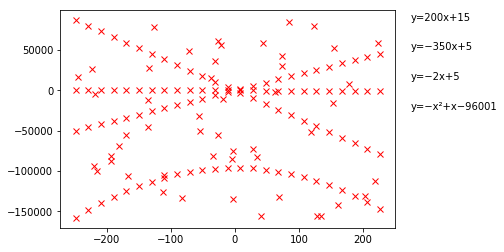

In [504]:
a=2080
b=[[0,-2,5],[0,-350,5],[0,200,15],[-1,1,-1]]
points=get_points(b=b,s=0,randDelta_x=5,count=4,power=2,randMIN_x=-250,randMAX_x=250,
           function_CountPoints =25,deltaGrafics=10,noise=True,Clone=False,noise_CountPoints=50,delta_noise=0)
plt.plot(points['x'],points['y'],'rx')

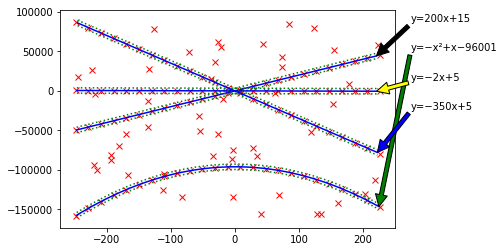

In [506]:
k=0
ab,t = find_function(points)
print_line_ab(points,ab,t)